Backlog prioritization sometimes leads to a difficult choice between two reasonable strategies or simultaneous business processes. Each one has its metrics or composite KPI. If we speak about the product analysis some choices are typical: attraction or conversion rate optimization, attraction or retention, remarketing or audience expansion. Some problems require complex approach – correlations between revenue/transaction frequency and micro KPIs like web conversion are unstable and have low statistical power. In this case machine learning (ML) techniques may give a value. Predictive power may be used to make a choice in favor of macro strategy. Secondly ML helps to reduce a dimension and simplify KPI – unsupervised learning techniques.  ML scoring is a solution when nonlinearity exists (unit economy equation is nonlinear, conversion depends on acquisition) or distribution of nonsystematic mistakes is far from normal distribution as well. 

Two groups of metrics are considered. First (I) corresponds to web conversion (bounce rate, micro conversion, depth). Second (II) corresponds to attraction of new visitors from organic channel (visits, viewers, views). The target function is a number of commercial offers per day converted into the sale. Features and target are normalized to the (0,1) interval. Relatively small data with daily sampling is used – 4 years of recording. Web metrics are parsed from analytical platform through Python API. Sales data is received from local CRM/SQL database – 'offers_cr' target. All offers are started by the call. (Web)=>(Contacts Page/Request Form/Chat)=>(Call)=>(Advisory Department)=>(Sales department). 

In [2]:
import numpy as np 
import pandas as pd 
from pandas import set_option
import matplotlib.pyplot as plt 
from pylab import plot, ylim, xlim, show, xlabel, ylabel, grid 
from numpy import linspace, loadtxt, ones, convolve
from statistics import median 
from statistics import mean 
from statistics import stdev 
from math import log
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import KFold 
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from operator import add
import seaborn as sns

Define custom functions:

In [38]:
def standart(x):#normalize to (0,1) interval
    max_value=x.max();
    min_value=x.min()
    z=(x-min_value)/(max_value - min_value)
    return z

def cormap(x):#correlation map
  corr=x.corr();fig=plt.figure(figsize=(10, 7))
  g=sns.heatmap(corr,annot=True,linewidths=.2, cbar_kws={"orientation": "horizontal"})
  plt.show()
    
def get_class(x):
    class_type=[]
    for item in list(x):
        if 0<=item<0.2:   class_type.append(0) #1 class  
        if 0.2<=item<0.4: class_type.append(1) #2 class
        if 0.4<=item<0.6:  class_type.append(2) #3 class
        if 0.6<=item<0.8:  class_type.append(3) #4 class
        if 0.8<=item<=1:  class_type.append(4) #5 class     
    return class_type

def pca(x,y):
  pca=PCA();pca.fit(y);PCA(copy=True)
  features=x;pca.explained_variance_=standart(pca.explained_variance_)
  pca.explained_variance_=list(np.array(pca.explained_variance_)*100)
  plt.bar(x, pca.explained_variance_,width=0.5);plt.xticks(features);plt.ylabel('variance');plt.xlabel('PCA feature')
  print('\nComponent importance:')
  for i in range(0,len(pca.explained_variance_)):
    print(str(x[i])+': '+str(int(pca.explained_variance_[i]))+'%')
    i=i+1
  plt.show()

Read data from files with crm and web data, parsed by webparse script from web analytics platform API.   

In [26]:
df_all=pd.read_excel('DATA_NEW/TRAFFIC.xlsx') #general web metrics
df_goal=pd.read_excel('DATA_NEW/WEB_CR.xlsx') #web conversion rate
df_crm=pd.read_excel('DATA_NEW/OFF_CR.xlsx') #commercial offers

df=df_all.merge(df_goal,how='left',left_on='Date',right_on='Date')#inner join of general web metrics and conversion metrics

del df['Viewers_y'];del df['Views_y'];del df['BR_y'];del df['Depth_y'];del df['Time_y'];df=df.fillna(0)
df['CR,%']=100*df['Visits_y']/df['Visits_x'];del df['Visits_y'] #calculate conversion rate
df=df.merge(df_crm,how='left',left_on='Date',right_on='Date') #inner join with crm data - offers per day and date
df['Offers']=df['Offers'].fillna(0);# rename the column

Rename columns.

In [27]:
df['Visits']=df['Visits_x'];df['Viewers']=df['Viewers_x']
df['Views']=df['Views_x'];del df['Visits_x'];del df['Viewers_x'];del df['Views_x'];del df['Time_x']

df['BR']=df['BR_x'];df['Depth']=df['Depth_x'];
df['CR']=df['CR,%'];del df['BR_x'];del df['Depth_x'];del df['CR,%']

df['OFFERS_CR']=df['Offers'];del df['Offers']
df=df.dropna()
print(df.head())

        Date  Visits  Viewers  Views    BR  Depth          CR  OFFERS_CR
0 2015-05-05       8        8     32   0.0    4.0   50.000000        2.0
1 2015-05-06       7        7     14   0.0    2.0   28.571429        1.0
2 2015-05-07       5        5      8  20.0    1.6   20.000000        0.0
3 2015-05-08       2        2      3   0.0    1.5    0.000000        1.0
4 2015-05-09       1        1      3   0.0    3.0  100.000000        0.0


In [28]:
column_names=list(df.columns.values)
print('All fields:',column_names)
print('\nData Start:',list(df['Date'])[0])
print('Data End:',list(df['Date'])[-1])
print('Number of records:', len(df))

All fields: ['Date', 'Visits', 'Viewers', 'Views', 'BR', 'Depth', 'CR', 'OFFERS_CR']

Data Start: 2015-05-05 00:00:00
Data End: 2019-06-22 00:00:00
Number of records: 1494


Convert features to the (0,1) interval except date:

In [29]:
date_list=list(df['Date'])
del df['Date']  

for item in df.columns.values: 
    df[item]=standart(df[item])         

Make correlation map and scatter map

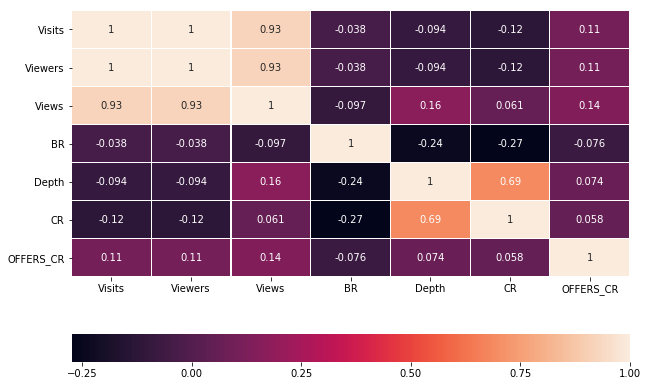

In [30]:
cormap(df)

Depth/CR and Visits/Viewers/Views are mutually correlated – correlation is 70% and more. It may be used for the dimension reduction of input features. The target (monetized Offers) is binned into the 5 equal intervals/classes. It is a price for a small amount of data. Less data – less number of intervals. 

In [31]:
description=df['OFFERS_CR'].describe()
print('Common description:\n')
print(description)
print('\nPercentile of 80%:',round(df['OFFERS_CR'].quantile(0.9),2))

Common description:

count    1494.000000
mean        0.095238
std         0.165674
min         0.000000
25%         0.000000
50%         0.000000
75%         0.142857
max         1.000000
Name: OFFERS_CR, dtype: float64

Percentile of 80%: 0.29


In [32]:
df_binary=df.copy()
df_binary['Offers_BIN']=get_class(df_binary['OFFERS_CR'])
del df_binary['OFFERS_CR']

Let's split features and target. Let's make an estimation of feature importance based on tree classifier first and principal component analysis. 


Input of components - Tree:
Visits:59.0%
Viewers:59.0%
Views:100.0%
BR:92.0%
Depth:99.0%
CR:83.0%

Component importance:
Visits: 100%
Viewers: 25%
Views: 4%
BR: 2%
Depth: 0%
CR: 0%
Offers_BIN: 0%


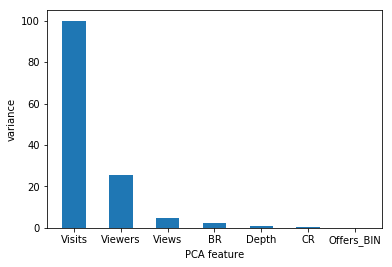

In [39]:
model=ExtraTreesClassifier(n_estimators=1000)
tree_features=['Visits','Viewers','Views','BR','Depth','CR','OFFERS_CR']

array=df_binary.values
X=array[:,0:6];Y=array[:,6]
model.fit(X,Y)
imp=list(model.feature_importances_)
imp=[round(x*100/max(imp)) for x in imp]

print('\nInput of components - Tree:')  
for x,y in zip(tree_features,imp): 
    print(str(x)+':'+str(y)+'%')
    
column_names=df_binary.columns
pca(column_names,df_binary)      

Visits/Viewers/Views give higher input in scattering of composite KPI according to Principle Component Analysis – see the figure below. It is clear that traffic has higher volatility (seasonality influence). First try with all features. We use ensemble of 6 voting estimators. Ensemble of seven nonlinear voting estimators from Python sklearn library is used: KNeighborsClassifier, Decision Tree, AdaBoost, GradientBoosting, Support Vector Classifier, Naïve Bayes and Multilayer Perceptron with three hidden layers. Diversification of qualitatively “different” weak (no tuning of hyperparameters) models provides the stability in relation to the new data. It is sufficiently important when working with small data. Hyper tuning is applied to KNeighborsClassifier only. First we use all input features. 

In [41]:
split_num=5 #number of splits for cross validation

#define split test#
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.5)
#/define split test#

#building the ensemble#
model=KNeighborsClassifier()
n_neighbors=np.arange(5,20,1)
param_grid=dict(n_neighbors=n_neighbors)
grid=GridSearchCV(estimator=model,param_grid=param_grid,cv=split_num,iid=True)
grid.fit(X, Y)

kn=KNeighborsClassifier(n_neighbors=grid.best_estimator_.n_neighbors);gb=GaussianNB()
dt=DecisionTreeClassifier(criterion='entropy');sv=SVC(gamma='auto')
ab=AdaBoostClassifier(n_estimators=100,random_state=7)
gb=GradientBoostingClassifier(n_estimators=100,random_state=7)
mlp=MLPClassifier(activation='relu', hidden_layer_sizes=(3,1), random_state=1, solver='lbfgs')

estimators=[]
estimators.extend([('kn',kn),('naive',gb),('dt',dt),('sv',sv),('ab',ab),('gb',gb),('mlp',mlp)])
ensemble=VotingClassifier(estimators)
#/building the ensemble#
   
#output of results#
results=cross_val_score(ensemble,X,Y,cv=split_num)
ensemble.fit(X_train,Y_train);score=ensemble.score(X_test,Y_test)
print('Accuracy of out-of-sample 50/50 test='+str(round(100*score))+'%')
print('Average score:'+str(round(100*mean(results),1))+str('%'))
print('Deviation of score:'+str(round(100*stdev(results),1))+str('%'))
#/output of results#

Accuracy of out-of-sample 50/50 test=80.0%
Average score:81.1%
Deviation of score:0.4%


Now remove all features except traffic metrics from the initial set.

In [13]:
df_binary=df.copy()
df_binary['Offers_BIN']=get_class(df_binary['OFFERS_CR'])
del df_binary['OFFERS_CR']

#define dataframe#
del df_binary['Depth']
del df_binary['CR']
del df_binary['BR']
#/define dataframe#

#define array#
array=df_binary.values
X=array[:,0:3];Y=array[:,3]
#/define array#

#define split test#
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.5)
#/define split test#
   
#output of results#
results=cross_val_score(ensemble,X,Y,cv=split_num)
results=cross_val_score(ensemble,X,Y,cv=split_num)
ensemble.fit(X_train,Y_train);score=ensemble.score(X_test,Y_test)
print('Accuracy of out-of-sample 50/50 test='+str(round(100*score))+'%')
print('Average score:'+str(round(100*mean(results)))+str('%'))
print('Deviation of score:'+str(round(100*stdev(results),1))+str('%'))
#/output of results#

Accuracy of out-of-sample 50/50 test=81.0%
Average score:80.0%
Deviation of score:2.4%


Now remove all features except conversion metrics from the initial set.

In [14]:
df_binary=df.copy()
df_binary['Offers_BIN']=get_class(df_binary['OFFERS_CR'])
del df_binary['OFFERS_CR']

#define dataframe#
del df_binary['Visits']
del df_binary['Views']
del df_binary['Viewers']
#/define dataframe#

#define array#
array=df_binary.values
X=array[:,0:3];Y=array[:,3]
#/define array#

#define split test#
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.5)
#/define split test#
   
#output of results#
results=cross_val_score(ensemble,X,Y,cv=split_num)
results=cross_val_score(ensemble,X,Y,cv=split_num)
ensemble.fit(X_train,Y_train);score=ensemble.score(X_test,Y_test)
print('Accuracy of out-of-sample 50/50 test='+str(round(100*score))+'%')
print('Average score:'+str(round(100*mean(results)))+str('%'))
print('Deviation of score:'+str(round(100*stdev(results),1))+str('%'))
#/output of results#

Accuracy of out-of-sample 50/50 test=79.0%
Average score:81.0%
Deviation of score:0.4%


The result is acceptable in both cases. Algorithm is able to “learn prediction of sales” using both groups. We may improve it only by tuning of models or by rough binning – less intervals. Now we may use mutual correlations of Depth/CR and Visits/Viewers/Views. We may transform initial traffic set to Views metric only (1D) – great simplification.

In [15]:
df_binary=df.copy()
df_binary['Offers_BIN']=get_class(df_binary['OFFERS_CR'])
del df_binary['OFFERS_CR']

#define dataframe#
del df_binary['Visits']
del df_binary['Viewers']
del df_binary['Depth']
del df_binary['CR']
del df_binary['BR']
#/define dataframe#

#define array#
array=df_binary.values
X=array[:,0:1];Y=array[:,1]
#/define array#

#define split test#
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.5)
#/define split test#
   
#output of results#
results=cross_val_score(ensemble,X,Y,cv=split_num)
results=cross_val_score(ensemble,X,Y,cv=split_num)
ensemble.fit(X_train,Y_train);score=ensemble.score(X_test,Y_test)
print('Accuracy of out-of-sample 50/50 test='+str(round(100*score))+'%')
print('Average score:'+str(round(100*mean(results)))+str('%'))
print('Deviation of score:'+str(round(100*stdev(results),1))+str('%'))
#/output of results#

Accuracy of out-of-sample 50/50 test=81.0%
Average score:81.0%
Deviation of score:0.4%


We will leave only micro web conversion from the second group.

In [16]:
df_binary=df.copy()
df_binary['Offers_BIN']=get_class(df_binary['OFFERS_CR'])
del df_binary['OFFERS_CR']

#define dataframe#
del df_binary['Visits']
del df_binary['Views']
del df_binary['Viewers']
del df_binary['BR']
del df_binary['Depth']
#/define dataframe#

#define array#
array=df_binary.values
X=array[:,0:1];Y=array[:,1]
#/define array#

#define split test#
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.5)
#/define split test#
   
#output of results#
results=cross_val_score(ensemble,X,Y,cv=split_num)
results=cross_val_score(ensemble,X,Y,cv=split_num)
ensemble.fit(X_train,Y_train);score=ensemble.score(X_test,Y_test)
print('Accuracy of out-of-sample 50/50 test='+str(round(100*score))+'%')
print('Average score:'+str(round(100*mean(results)))+str('%'))
print('Deviation of score:'+str(round(100*stdev(results),1))+str('%'))
#/output of results#

Accuracy of out-of-sample 50/50 test=80.0%
Average score:81.0%
Deviation of score:0.4%


So Product Owner may take into account Prediction Power, Risks and Budget for any of two strategies. In this very case Conversion Rate Optimization (CRO) is cheaper than SEO or Ads and has less influence of seasonality. In this case CRO is preferred until results are updated. The proposed method may be generalized in decision making when nonlinearity and the implicit connections between behavior of user and monetization are inevitable. However more simple instruments are preferable if the funnel is linear, short and simple. Combination of both approaches with intuition may give a confidence when making “expensive” decisions.